### 붓꽃(Iris) 데이터 셋을 이용한 클러스터 평가
- 실루엣분석 : 각 군집간의 거리가 얼마나 효율적으로 분리되 있는지
- 실루엣 계수(silhouette coefficient) : -1 ~ 1 사이 값. 1에 가까울수록 좋다.
-  1에 가까울수록 근처의 군집과 떨어져 있다는 것, - 값은 아예 다른 군집에 데이터 포인트가 할당됐음을 뜻함.

In [1]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(irisDF)

irisDF['cluster'] = kmeans.labels_

# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
irisDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

irisDF.head(3)

silhouette_samples( ) return 값의 shape (150,)
붓꽃 데이터셋 Silhouette Analysis Score:0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315


In [2]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.451105
1    0.798140
2    0.417320
Name: silhouette_coeff, dtype: float64

### 클러스터별 평균 실루엣 계수의 시각화를 통한 클러스터 개수 최적화 방법

In [3]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

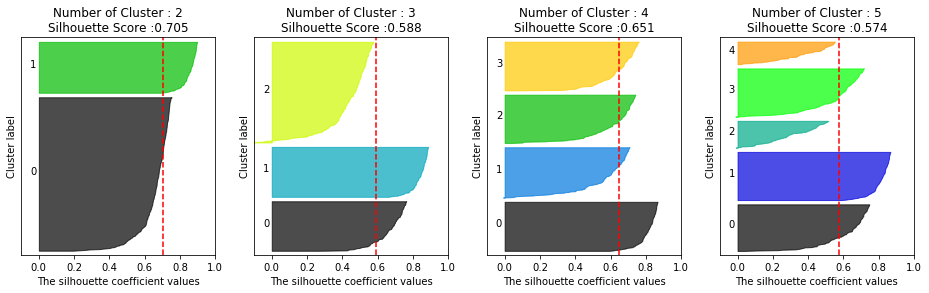

In [4]:
# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X)

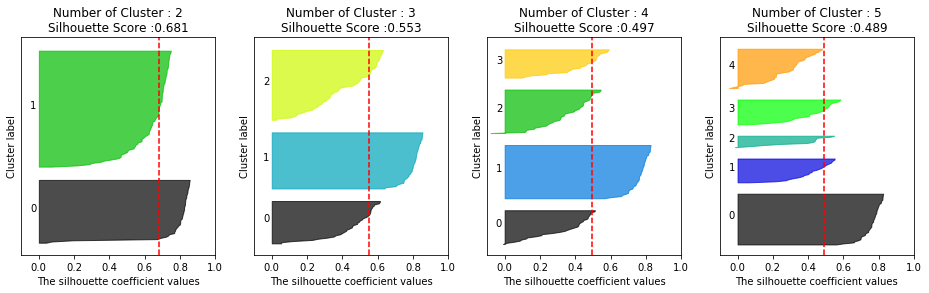

In [5]:
from sklearn.datasets import load_iris

iris=load_iris()
visualize_silhouette([ 2, 3, 4,5 ], iris.data)